# Alternative Implementation using a self-programmed breadth-first search

In [1]:
import numpy as np
import xarray as xr

import tricco
from tricco.alternatives import ownbfs 

## 1. Load grid and data 

In [2]:
gridfile = "./data/icon-grid_nawdex_78w40e23n80n_R80000m.nc"
grid = ownbfs.prepare_grid(model="ICON", file=gridfile)

datafile = "./data/nawdexnwp-80km-mis-0001_2016092200_2d_30min_DOM01_ML_0060.nc"
data = xr.open_dataset(datafile)["clct"].squeeze()

## 2. Compute connected components for vertex and edge connectivity. Result is a list of connected components ordered by size, where each connected component is a list of cell indices.

In [3]:
components_vert=ownbfs.compute_components_2d(grid, data, 85.0, connectivity="vertex")
components_edge=ownbfs.compute_components_2d(grid, data, 85.0, connectivity="edge")

Map connected components on the structure of the field input data, with the value indicating the connected component. Needed for plotting.

In [4]:
ncells = grid.cell.size

field_cc_vert = np.zeros(ncells)
for icomp in range(len(components_vert)):
    field_cc_vert[list(components_vert[icomp])]=icomp+1

field_cc_edge = np.zeros(ncells)
for icomp in range(len(components_edge)):
    field_cc_edge[list(components_edge[icomp])]=icomp+1

## 3. Plotting. Same as in example-2d.ipynb for the tricco cubulation implementation.

Define a qualitative colormap that cycles through the colors of the matplotlib Set1 colormap, and that always plots 0 as white.

In [5]:
def make_colormap(ncolors):
    import matplotlib as mpl    
    cmap_base = plt.cm.Set1 # note: number of colors of base color map is given by cmap_base.N
    cmaplist_base = [cmap_base(i) for i in range(cmap_base.N)]
    cmaplist = [(1, 1, 1, 1.0)] # need to have white as first color for the triangles with no connected component
    for i in range(ncolors-1):
        icolor = np.mod(i,cmap_base.N)
        cmaplist.append(cmaplist_base[icolor])
    return mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, ncolors)

Create 2x2 panel plot with original cloud field, thresholded cloud field and connected components.

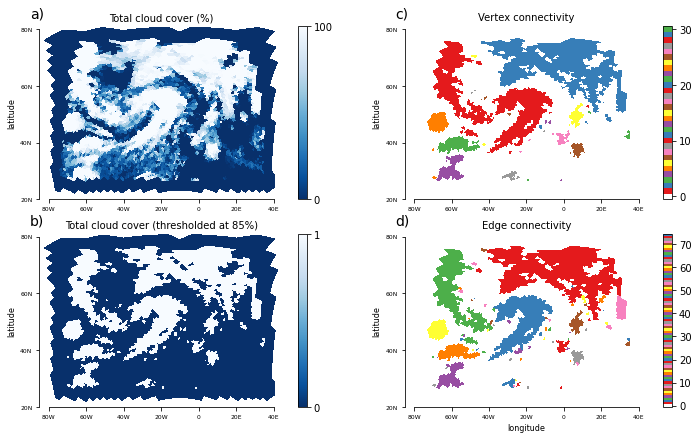

In [6]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri

rad2deg=180.0/np.pi

import xarray as xr
grid_plot  = xr.load_dataset("./data/icon-grid_nawdex_78w40e23n80n_R80000m.nc")
vlat = rad2deg*grid_plot["vlat"].values
vlon = rad2deg*grid_plot["vlon"].values
# we need to subtract -1 from vertex_of_cell as python starts counting at 0, but fortran starts at 1
vertex_of_cell= grid_plot["vertex_of_cell"].values-1
del grid_plot

datafile = "./data/nawdexnwp-80km-mis-0001_2016092200_2d_30min_DOM01_ML_0060.nc"
field    = xr.open_dataset(datafile)["clct"].squeeze()
field_thresholded = np.where(field<85.0, 0, 1)

def make_niceplot(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_bounds(20,80)
    ax.spines['bottom'].set_bounds(-80,40)
    ax.yaxis.set_ticks([20,40,60,80])
    ax.yaxis.set_ticklabels(['20N','40N','60N','80N'], fontsize=6)
    ax.xaxis.set_ticks([-80,-60,-40,-20,0,20,40])
    ax.xaxis.set_ticklabels(['80W','60W','40W','20W','0','20E','40E'], fontsize=6)
    plt.xlim(-85,45); plt.ylim(20,81);
    plt.ylabel('latitude', fontsize=8)
    
# plotting
plt.figure(figsize=(12,7))

ax=plt.subplot(2,2,1); make_niceplot(ax)
plt.title('Total cloud cover (%)', fontsize=10)
c=plt.tripcolor(vlon, vlat, vertex_of_cell.transpose(), facecolors=field,
                vmin=0, vmax=100, edgecolors='none', cmap=plt.get_cmap('Blues_r'))
plt.colorbar(c, ticks=[0,100]);
plt.text(-90,88, 'a)', color='k', size=14, ha='left', va='top')

ax=plt.subplot(2,2,3); make_niceplot(ax)
plt.title('Total cloud cover (thresholded at 85%)', fontsize=10)
c=plt.tripcolor(vlon, vlat, vertex_of_cell.transpose(), facecolors=field_thresholded, 
                vmin=0, vmax=1, edgecolors='none', cmap=plt.get_cmap('Blues_r'))
plt.colorbar(c, ticks=[0,1]);
plt.text(-90,88, 'b)', color='k', size=14, ha='left', va='top')

ax=plt.subplot(2,2,2); make_niceplot(ax)
plt.title('Vertex connectivity', fontsize=10); make_niceplot(ax)
c=plt.tripcolor(vlon, vlat, vertex_of_cell.transpose(), facecolors=field_cc_vert, 
                vmin=-0.5, vmax=len(components_vert)+0.5, edgecolors='none', cmap=make_colormap(ncolors=len(components_vert)+1))
plt.colorbar(c, ticks=[i for i in range(0,len(components_vert)+1,10)]);
plt.text(-90,88, 'c)', color='k', size=14, ha='left', va='top')

ax=plt.subplot(2,2,4); make_niceplot(ax)
plt.title('Edge connectivity', fontsize=10); make_niceplot(ax)
c=plt.tripcolor(vlon, vlat, vertex_of_cell.transpose(), facecolors=field_cc_edge, 
                vmin=-0.5, vmax=len(components_edge)+0.5, edgecolors='none', cmap=make_colormap(ncolors=len(components_edge)+1))
plt.colorbar(c, ticks=[i for i in range(0,len(components_edge)+1,10)]);
plt.xlabel('longitude', fontsize=8);
plt.text(-90,88, 'd)', color='k', size=14, ha='left', va='top');

plt.savefig("./alternative_own-bfs_2d.pdf")